In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycbc
import os, time, h5py
from IPython.display import display, clear_output

In [2]:
sample_rate = 4096
duration = 6.
dt=1./sample_rate

f0 = 20.
f_low = 20.
f_high =  2048.
df = 1.
m1_min = 1.
m1_max = 99.
m2_min = m1_min
m2_max = m1_max
max_total_m = 100.
max_spin = 0.99

min_match = 0.97
filter_cutoff = 'SchwarzISCO'
psd_model = 'aLIGODesignSensitivityP1200087'

outfile='template_bank.xml'
template_file='templates'
signal_file='signal'
noise_file='noise'

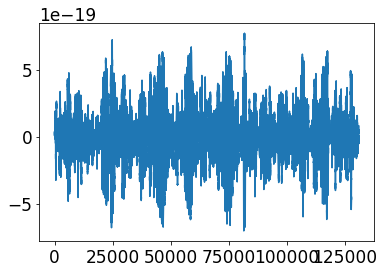

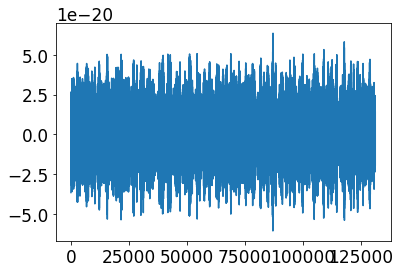

In [3]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")
strain = merger.strain('H1')
plt.plot(strain)
plt.show()
strain = resample_to_delta_t(highpass(strain, f_low), dt)
#plt.plot(strain[75000:100000])
plt.plot(strain)
plt.show()

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
conditioned = strain.crop(8, 8)
#conditioned = strain.crop(2, 2)
noise = strain.crop(16, 0)
psd = conditioned.psd(1)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(sample_rate),
                                  low_frequency_cutoff=f_low)
print(len(conditioned))
print(len(noise))

65536
65536


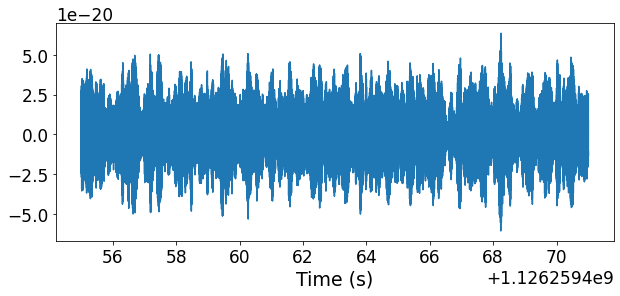

In [5]:
plt.figure(figsize=[10, 4])
plt.plot(conditioned.sample_times, conditioned)
plt.xlabel('Time (s)')
plt.show()

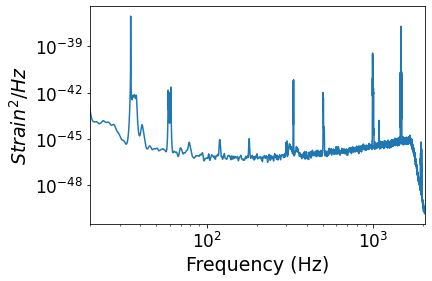

In [6]:
plt.loglog(psd.sample_frequencies, psd)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(f_low, f_high)
plt.show()

In [7]:
!echo "pycbc_geom_aligned_bank --pn-order twoPN --f0 {f0} --f-low {f_low} --f-upper {f_high} --delta-f {df} --min-match {min_match} --min-mass1 {m1_min} --min-mass2 {m2_min} --max-mass1 {m1_max} --max-mass2 {m2_max} --verbose --output-file {outfile} --calculate-ethinca-metric --filter-cutoff {filter_cutoff} --psd-model {psd_model} --max-total-mass {max_total_m} --max-bh-spin-mag {max_spin}"

pycbc_geom_aligned_bank --pn-order twoPN --f0 20.0 --f-low 20.0 --f-upper 2048.0 --delta-f 1.0 --min-match 0.97 --min-mass1 1.0 --min-mass2 1.0 --max-mass1 99.0 --max-mass2 99.0 --verbose --output-file template_bank.xml --calculate-ethinca-metric --filter-cutoff SchwarzISCO --psd-model aLIGODesignSensitivityP1200087 --max-total-mass 100.0 --max-bh-spin-mag 0.99


In [8]:
if not os.path.isfile(outfile):
    !echo "pycbc_geom_aligned_bank --pn-order twoPN --f0 {f0} --f-low {f_low} --f-upper {f_high} --delta-f {df} --min-match {min_match} --min-mass1 {m1_min} --min-mass2 {m2_min} --max-mass1 {m1_max} --max-mass2 {m2_max} --verbose --output-file {outfile} --calculate-ethinca-metric --filter-cutoff {filter_cutoff} --psd-model {psd_model} --max-total-mass {max_total_m} --max-bh-spin-mag {max_spin}"
    !pycbc_geom_aligned_bank --pn-order twoPN --f0 {f0} --f-low {f_low} --f-upper {f_high} --delta-f {df} --min-match {min_match} --min-mass1 {m1_min} --min-mass2 {m2_min} --max-mass1 {m1_max} --max-mass2 {m2_max} --verbose --output-file {outfile} --calculate-ethinca-metric --filter-cutoff {filter_cutoff} --psd-model {psd_model} --max-total-mass {max_total_m} --max-bh-spin-mag {max_spin}

In [9]:
datafreq = np.fft.fftfreq(len(conditioned))*sample_rate
psd_ = np.interp(datafreq, np.array(psd.sample_frequencies), np.array(psd))
np.save('psd',psd_)

In [10]:
from pycbc.waveform.bank import TemplateBank

waveforms = TemplateBank(outfile)

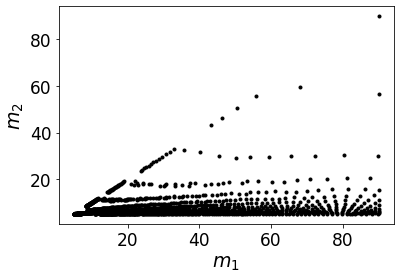

In [11]:
%matplotlib inline

plt.scatter(waveforms.table['mass1'],waveforms.table['mass2'],marker='.',color='black')
plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.show()

In [12]:
m1s = waveforms.table['mass1']
m2s = waveforms.table['mass2']
s1s = waveforms.table['spin1z']
s2s = waveforms.table['spin2z']

In [13]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import make_frequency_series
from pycbc.types import TimeSeries, FrequencySeries

templates = []
hps= []
hps_f= []

if True:
    
    M = int(2**(8))

    #N, M = initial_states.shape[0], initial_states.shape[1]
    bank_file = 'H1L1-BANK2HDF_SPLITBANK_BANK0_INJECTIONS-1134450017-1202400.hdf'
    full_bank = h5py.File(bank_file,'r')

    bank_size = full_bank['mass1'].size
    
    templates = []

    for i in np.arange(bank_size)[::int(bank_size//M)]:
        print(float(full_bank['mass1'][i]),float(full_bank['mass2'][i]))
        waveform = get_td_waveform(approximant="IMRPhenomPv3",
                            mass1=float(full_bank['mass1'][i]),
                            mass2=float(full_bank['mass2'][i]),#spin1z=0.,#float(full_bank['spin1z'][i]),spin2z=0.,#float(full_bank['spin2z'][i]),
                            delta_t=dt,
                            f_lower=f_low)#float(full_bank['f_lower'][i]))
            
        waveform[0].resize(len(conditioned))
        hps.append(waveform[0])
        hps_f.append(np.array(make_frequency_series(TimeSeries(waveform[0],delta_t=dt))))
        fhp = np.fft.fft(np.array(waveform[0]))
        sq = np.abs((fhp * fhp.conjugate() / psd_).sum())
        norm = 4. / np.sqrt(4. * np.abs(datafreq[1]-datafreq[0]) * sq)
        templates.append((fhp/psd_)*norm)
    templates = np.array(templates)
    np.save(template_file,templates)
    print('Done!')
    
if False:
    
    M = int(2**(3))
    
    dm = (m1_max-m1_min)/np.floor(np.sqrt(2.*M))
    m1s = np.arange(m1_min,m1_max,dm)
    print(m1s)
    templates = []
    i=0
    for m1 in m1s:
        m2 = m1
        while m2<m1_max and i<M:
            #clear_output(wait=True)
            #display("Generated template "+str(i+1)+" of "+str(M)+"...")
            waveform = get_td_waveform(approximant="IMRPhenomPv3",
                                 mass1=float(m1),
                                 mass2=float(m2),
                                 spin1z=0.,
                                 spin2z=0.,
                                 delta_t=dt,
                                 f_lower=f_low)
            waveform[0].resize(len(conditioned))
            hps.append(waveform[0])
            hps_f.append(np.array(make_frequency_series(TimeSeries(waveform[0],delta_t=dt))))
            fhp = np.fft.fft(np.array(waveform[0]))
            sq = np.abs((fhp * fhp.conjugate() / psd_).sum())
            norm = 4. / np.sqrt(4. * np.abs(datafreq[1]-datafreq[0]) * sq)
            templates.append((fhp/psd_)*norm)
            i+=1
            m2+=dm
    templates = np.array(templates)
    np.save(template_file,templates)
    print('Done!')

if False:
    i=0
    for m1,m2,s1,s2 in zip(m1s,m2s,s1s,s2s):
        clear_output(wait=True)
        display("Generated template "+str(i+1)+" of "+str(len(m1s))+"...")
        waveform = get_td_waveform(approximant="SEOBNRv4_opt",
                                 mass1=float(m1),
                                 mass2=float(m2),
                                 spin1z=float(s1),
                                 spin2z=float(s2),
                                 delta_t=dt,
                                 f_lower=f_low)
        waveform[0].resize(len(conditioned))
        hps.append(waveform[0])
        fhp = np.fft.fft(np.array(waveform[0]))
        sq = np.abs((fhp * fhp.conjugate() / psd_).sum())
        norm = 4. / np.sqrt(4. * np.abs(datafreq[1]-datafreq[0]) * sq)
        templates.append((fhp/psd_)*norm)
        i+=1

    templates = np.array(templates)
    np.save(template_file,templates)
    print('Done!')

4.53513765335083 1.0307602882385254
5.578952789306641 2.3842105865478516
3.522845983505249 1.0215249061584473
10.169207572937012 1.032916784286499
15.788984298706055 1.0172243118286133
2.122188091278076 1.983302116394043
3.614854574203491 2.3060686588287354
58.12382125854492 1.1218531131744385
2.098672866821289 1.1351131200790405
4.628648281097412 1.031617522239685
4.658993721008301 1.256493091583252
4.006453990936279 1.0766037702560425
2.1012096405029297 1.3904063701629639
3.0339484214782715 2.000808000564575
2.0061988830566406 1.264003872871399
26.375659942626953 1.408657431602478
2.830477476119995 2.1438591480255127
5.633630275726318 5.02297830581665
53.196678161621094 1.0301406383514404
11.990687370300293 2.074126958847046
8.016525268554688 1.0122911930084229
43.76441192626953 1.112112283706665
28.72198486328125 1.0863200426101685
1.1807634830474854 1.1807634830474854
15.414019584655762 1.3752092123031616
9.116691589355469 1.0683934688568115
20.698028564453125 1.0306799411773682
2.

36.56801223754883 1.2929991483688354
1.2091275453567505 1.0021870136260986
3.5351603031158447 1.6555688381195068
7.671069622039795 1.871569037437439
15.337385177612305 2.6943793296813965
9.877222061157227 6.102149963378906
2.2529613971710205 1.0008105039596558
4.653260707855225 1.0750094652175903
101.73683166503906 3.1202762126922607
2.940384864807129 1.0129679441452026
40.72804641723633 3.789846181869507
3.8890292644500732 1.0918422937393188
89.19992065429688 1.0562381744384766
5.2345781326293945 1.4888728857040405
2.5597431659698486 1.0582195520401
54.72615051269531 1.1304348707199097
3.0603578090667725 1.14206063747406
3.146212339401245 2.0255565643310547
4.514611721038818 1.005884051322937
3.2777183055877686 2.4338982105255127
127.31336212158203 1.4141019582748413
84.0704345703125 1.1052495241165161
2.731168508529663 1.009432077407837
1.182992935180664 1.0921229124069214
39.91722106933594 1.5442293882369995
2.014029026031494 1.0973596572875977
62.472747802734375 1.3447544574737549


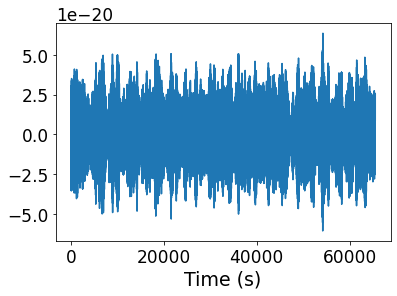

In [14]:
plt.plot(conditioned)
plt.xlabel('Time (s)')
plt.show()

In [15]:
def my_matched_filter(data, template):
    return data*template.conjugate()

In [16]:
signal = make_frequency_series(TimeSeries(np.array(conditioned), delta_t=dt))
noise = make_frequency_series(TimeSeries(np.array(noise), delta_t=dt))
np.save(signal_file,signal)
np.save(noise_file,noise)
df = np.abs(datafreq[1]-datafreq[0])
print(df)

0.0625


In [17]:
from pycbc.filter import matched_filter

SNRs = []
signal_f = np.array(signal)


for template,hp_f,hp in zip(templates,hps_f,hps):
    template_f = np.array(make_frequency_series(TimeSeries(hp, delta_t=dt)))
    snr_ = matched_filter(FrequencySeries(hp_f, delta_f=df), 
                                   FrequencySeries(signal_f, delta_f=df), 
                                   psd=FrequencySeries(psd_,delta_f=df))
    snr_ = np.array(snr_.crop(2, 2))
    print(np.max(np.abs(snr_)))
    SNRs.append(np.max(np.abs(snr_)))
SNRs = np.array(SNRs)
#print(SNRs)

4.616975074415436
3.8536139827859777
4.270206093667779
3.988124026510187
4.861580067481769
4.46501931699267
3.9088693029227484
3.011724235664877
4.01471561723538
4.671635853774316
2.57062831263111
4.739777147594137
4.945407696716969
3.512920618276673
4.94713949822594
3.549017035803343
3.0884601475752214
3.562883678218761
3.695426760438521
3.063790318397775
3.93449538294087
2.91918504395606
4.494068719817828
4.966095295196998
3.5737554679736623
3.885991688966254
4.517207024510699
5.112428164084388
3.2103578836204614
4.156746990553161
3.8706600557600304
5.825857565278242
3.7341963113727017
4.806999989016379
4.91005226226726
4.19451369450159
3.267192269474997
4.717385369514999
5.62405776613573
4.605853963069135
8.20190184018575
3.9140182241506567
3.830227202796982
3.5821275662699996
4.908050864955715
4.62968248983922
4.509071617097555
4.0247770566074355
5.003843797310331
4.116328945602811
3.7277465415959936
4.47169997483356
5.10111758417517
6.616660810092285
4.958452097776098
3.9967548163

In [18]:
from pycbc.filter import matched_filter

SNRs = []
signal_f = np.array(noise)
for template,hp_f,hp in zip(templates,hps_f,hps):
    template_f = np.array(make_frequency_series(TimeSeries(hp, delta_t=dt)))
    snr_ = matched_filter(FrequencySeries(hp_f, delta_f=df), 
                                   FrequencySeries(signal_f, delta_f=df), 
                                   psd=FrequencySeries(psd_,delta_f=df))
    snr_ = np.array(snr_.crop(4 + 4, 4))
    print(np.max(np.abs(snr_)))
    SNRs.append(np.max(np.abs(snr_)))
SNRs = np.array(SNRs)
#print(SNRs)

4.508330853162868
4.126001468738671
3.984410094062569
4.185187465705545
3.9135389396970486
4.297766568925842
3.338768407806116
2.8391081866471217
3.7064934369212583
4.608335704275506
2.4211251102510727
4.628759266964935
4.778044260097121
3.6205343004684196
4.7806718804358
3.236533172156055
2.8836545270336558
3.577085844346932
3.1632686958460643
3.0617729362640493
4.617801030711691
2.848236606592188
3.115418829250588
4.695819342069431
3.063351123688763
4.100819913519414
3.908367821038228
5.654174232397899
3.0048476060186076
4.021874912014299
4.4198083986592245
4.439082887926429
3.6142496752983693
4.745474974540392
4.765583871674583
4.553693722089842
3.3595860991056443
2.878906235771259
3.8871103641985854
4.583341297945532
4.236257711637308
4.1637460977493115
4.5290884621917336
3.9795953585987296
4.723074510187333
4.969553613121104
4.610872133965784
3.8038248908255055
4.9384169323059615
3.221720263956843
4.669496045616818
4.572262610100535
4.78887247884347
6.1132295986690615
3.8417587290

In [19]:
SNR_threshold=18.

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1440 but corresponding boolean dimension is 257

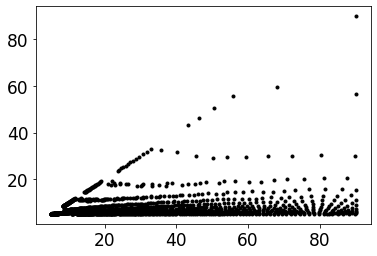

In [20]:
%matplotlib inline

plt.scatter(waveforms.table['mass1'],waveforms.table['mass2'],marker='.',color='black')
plt.scatter(waveforms.table['mass1'][SNRs>SNR_threshold],waveforms.table['mass2'][SNRs>SNR_threshold],marker='.',color='orange')

plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.show()

In [ ]:
max_ind = np.argmax(SNRs)
print(waveforms.table['mass1'][max_ind],waveforms.table['mass2'][max_ind])

In [ ]:
print(np.fft.ifft(templates[0]))
print(np.fft.ifft(templates[0]*psd_))

#for template in templates:
#    print(my_matched_filter(np.array(conditioned), np.fft.ifft(template)))
#    print(my_matched_filter(signal, template))
#    break

In [ ]:
print(np.mean(np.abs(np.real(np.fft.ifft(templates[0]*psd_)))))

In [ ]:
print(datafreq[1]-datafreq[0])

In [ ]:
print(m1s)